In [86]:
import collections
import ase.data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model

import sklearn.metrics

from xenonpy.descriptor import Compositions

In [20]:
dataset_path = './DigitalEcosystem/raw_data/perovskites.pkl'
df = pd.read_pickle(dataset_path)
df["Volume"] /= df["Atoms_Object"].apply(lambda atoms: len(atoms)//5)

# Featurize with XenonPy
cal = Compositions()
df["Symbols"] = df.Atoms_Object.apply(lambda atoms: collections.Counter(atoms.get_chemical_symbols()))
featurized_data = pd.concat([df, cal.transform(df.Symbols)], axis=1)
featurized_data

,Formula,Atoms_Object,Volume,Symbols,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,AgCl3K,"(Atom('K', [2.546784180928994, 2.5467841809289...",132.452162,"{'K': 1, 'Ag': 1, 'Cl': 3}",23.4,164.212290,215.4,22.340,50.663300,849.560,...,1.0,3.0,0.237,0.00890,175.0,182.0,207.0,314.8,206.0,2.180
1,La2N6W2,"(Atom('La', [2.665318694121161, 2.857224133724...",65.894295,"{'La': 2, 'W': 2, 'N': 6}",30.4,120.800000,214.8,16.786,72.953294,1978.440,...,2.0,2.0,0.133,0.02583,155.0,166.0,193.0,309.6,333.6,1.100
2,O3SrV,"(Atom('Sr', [1.9322684339857643, 1.93226843398...",57.715487,"{'Sr': 1, 'V': 1, 'O': 3}",17.0,157.520852,208.8,16.810,37.311700,1115.514,...,2.0,2.0,0.301,0.02658,152.0,150.0,182.0,314.4,317.5,0.802
3,Cl6Cs2Tl2,"(Atom('Cs', [7.926562986915786, 0.0, 0.0289390...",176.625755,"{'Cs': 2, 'Tl': 2, 'Cl': 6}",37.4,176.012290,221.8,28.660,88.727090,679.480,...,1.0,3.0,0.128,0.00890,175.0,182.0,207.0,394.7,206.0,2.180
4,F3MnRb,"(Atom('Rb', [2.1409860345006186, 2.14098603450...",78.511177,"{'Rb': 1, 'Mn': 1, 'F': 3}",17.8,157.014169,194.2,22.918,39.480211,690.206,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,296.1,1300.0,0.557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,F6In2Mn2,"(Atom('In', [3.004706503626541, 3.051648750812...",77.734000,"{'In': 2, 'Mn': 2, 'F': 6}",20.2,140.614169,195.4,14.878,45.350251,968.606,...,2.0,2.0,0.234,0.02770,147.0,146.0,171.0,296.1,1215.0,0.557
140,CaF3Rb,"(Atom('Rb', [2.259732663194181, 2.259732663194...",92.312641,"{'Rb': 1, 'Ca': 1, 'F': 3}",16.8,169.414169,199.8,27.420,36.508202,594.606,...,1.0,2.0,0.360,0.02770,147.0,146.0,171.0,336.4,1300.0,0.557
141,MoNaO3,"(Atom('Na', [0.0, 0.0, 0.0], index=0), Atom('M...",59.086370,"{'Na': 1, 'Mo': 1, 'O': 3}",15.4,153.520852,196.4,15.020,33.387354,1262.334,...,1.0,2.0,0.251,0.02658,152.0,150.0,182.0,298.3,317.5,0.802
142,KO3W,"(Atom('K', [0.0, 0.0, 0.0], index=0), Atom('W'...",62.178694,"{'K': 1, 'W': 1, 'O': 3}",23.4,162.920852,200.0,19.366,54.187060,1449.514,...,1.0,2.0,0.133,0.02658,152.0,150.0,182.0,309.6,317.5,0.802


In [103]:
def mape(x):
    mape = sklearn.metrics.mean_absolute_percentage_error(y_pred=x, y_true=df['Volume'])
    return np.round(mape, 3)

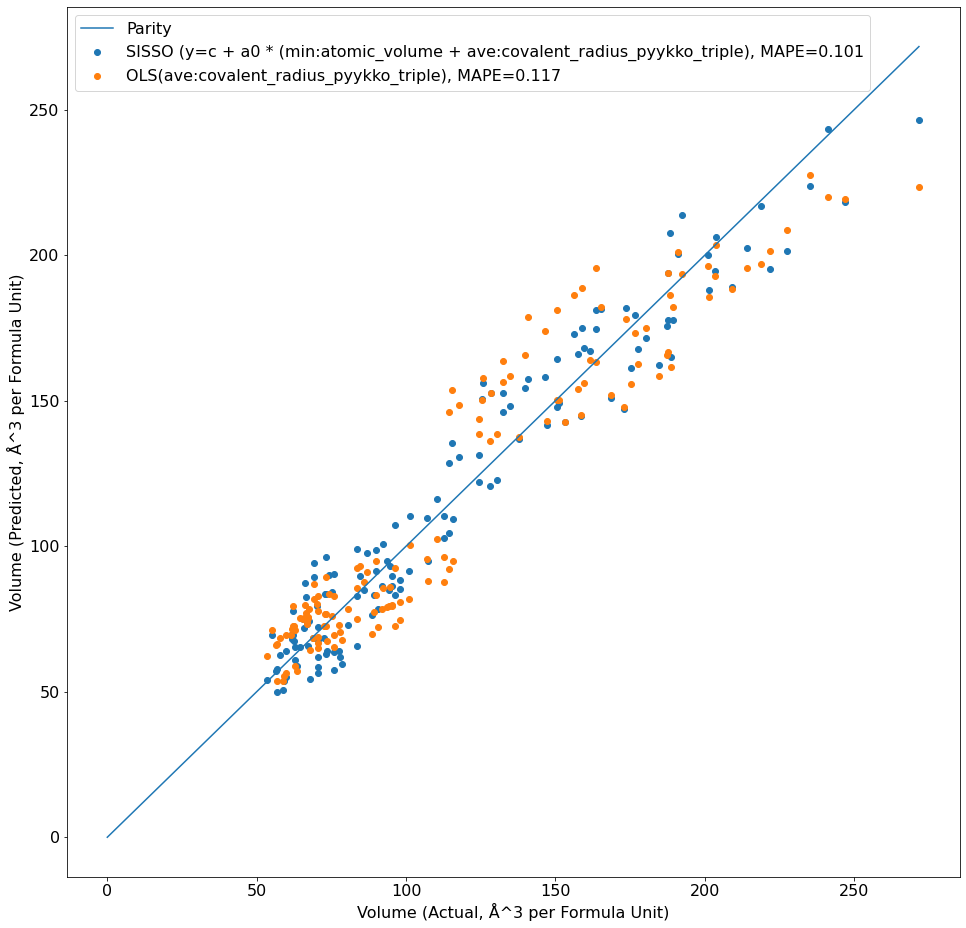

In [118]:
sisso_preds = -172 + 2.63 * (featurized_data["min:atomic_volume"] + featurized_data["ave:covalent_radius_pyykko_triple"])

summed_covalent_radii = df["Atoms_Object"].apply(lambda atoms: sum(ase.data.covalent_radii[atoms.get_atomic_numbers()])).to_numpy().reshape(-1,1)
model = sklearn.linear_model.LinearRegression()

ave = featurized_data["ave:covalent_radius_pyykko_triple"].to_numpy().reshape(-1,1)
model.fit(ave, df["Volume"])
ols_preds_ave = model.predict(ave)

mins = featurized_data['min:atomic_volume'].to_numpy().reshape(-1,1)
model.fit(mins, df['Volume'])
ols_preds_min = model.predict(mins)

sums = featurized_data["sum:covalent_radius_pyykko_triple"].to_numpy().reshape(-1,1)
model.fit(sums, df["Volume"])
ols_preds_sum = model.predict(sums)

plt.rcParams['figure.figsize'] = [16,16]
plt.rcParams['font.size'] = 16

plt.scatter(x=df["Volume"], y=sisso_preds, label=f"SISSO (y=c + a0 * (min:atomic_volume + ave:covalent_radius_pyykko_triple), MAPE={mape(sisso_preds)}")
plt.scatter(x=df["Volume"], y=ols_preds_ave, label=f"OLS(ave:covalent_radius_pyykko_triple), MAPE={mape(ols_preds_ave)}")
#plt.scatter(x=df['Volume'], y=ols_preds_min, label=f"OLS(min:atomic_volume), MAPE={mape(ols_preds_min)}")

#plt.scatter(x=df["Volume"], y=ols_preds_sum, label=f"OLS(sum:covalent_radius_pyykko_triple), MAPE={mape(ols_preds_sum)}")

plt.plot([0,max(df["Volume"])], [0,max(df["Volume"])], label="Parity")
plt.ylabel("Volume (Predicted, Å^3 per Formula Unit)")
plt.xlabel("Volume (Actual, Å^3 per Formula Unit)")
plt.legend()